In [1]:
%%html
<style>
body {
    font-family: "Tw Cen MT", cursive, sans-serif;
}
</style> 

# POS tagging using modified Viterbi

>  By : Ayush Soni

## Business Problem 

The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag. <br>
The problem at hand deals with improving the accuracy of the above discussed algorithm.

## Data Description

For this assignment, we will use the Treebank dataset of NLTK with the 'universal' tagset. The Universal tagset of NLTK comprises only 12 coarse tag classes as follows: Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.

We are only using 2 coarse classes (compared to the 46 fine classes such as NNP, VBD etc.) which inturn will make the Viterbi algorithm faster as well.

## Objective

You need to accomplish the following in this assignment:

1. Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
2. Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
3. Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
4. List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

## Analysis

Let us now import the required libraries to get started.

In [2]:
import nltk, re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import itertools
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = "plotly_white"

## Data Preparation

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
nltk_data[:2]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

Let's split the dataset into train and test. We will keep the train,test ratio as 95:5.

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)

print("Length of Training Set -", len(train_set))
print("Length of Test Set -", len(test_set))
print("-" * 120)
print("Glimpse of training -\n")
print(train_set[:10])

Length of Training Set - 3718
Length of Test Set - 196
------------------------------------------------------------------------------------------------------------------------
Glimpse of training -

[[('And', 'CONJ'), ('8', 'NUM'), ('%', 'NOUN'), ('*ICH*-1', 'X'), ('said', 'VERB'), ('0', 'X'), ('export', 'NOUN'), ('orders', 'NOUN'), ('were', 'VERB'), ('down', 'ADV'), ('last', 'ADJ'), ('month', 'NOUN'), (',', '.'), ('compared', 'VERB'), ('with', 'ADP'), ('6', 'NUM'), ('%', 'NOUN'), ('the', 'DET'), ('month', 'NOUN'), ('before', 'ADV'), ('.', '.')], [('The', 'DET'), ('Big', 'NOUN'), ('Three', 'NOUN'), ('auto', 'NOUN'), ('makers', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('the', 'DET'), ('rule', 'NOUN'), ('changes', 'NOUN'), ('were', 'VERB'), ("n't", 'ADV'), ('surprising', 'ADJ'), ('because', 'ADP'), ('Bush', 'NOUN'), ('administration', 'NOUN'), ('officials', 'NOUN'), ('have', 'VERB'), ('long', 'ADV'), ('said', 'VERB'), ('0', 'X'), ('they', 'PRON'), ('planned', 'VERB'), ('*-1', 'X'), ('to', 

In [5]:
# Get list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]

Lets have a glimpse of training set.

In [6]:
# Let's have a look at the tagged words in the training set

train_tagged_words[:10]

[('And', 'CONJ'),
 ('8', 'NUM'),
 ('%', 'NOUN'),
 ('*ICH*-1', 'X'),
 ('said', 'VERB'),
 ('0', 'X'),
 ('export', 'NOUN'),
 ('orders', 'NOUN'),
 ('were', 'VERB'),
 ('down', 'ADV')]

Let's see the total number of tagged words in the train set.

In [7]:
len(train_tagged_words)

95990

In [8]:
# tokens in the train set - train_tagged_words
train_data_tokens = [pair[0] for pair in train_tagged_words]
train_data_tokens[:10]

['And', '8', '%', '*ICH*-1', 'said', '0', 'export', 'orders', 'were', 'down']

Lets look at the POS tags assigned to words.

In [9]:
# POS tags for the tokens in the train set -

train_data_pos_tags = [pair[1] for pair in train_tagged_words]
train_data_pos_tags[:10]

['CONJ', 'NUM', 'NOUN', 'X', 'VERB', 'X', 'NOUN', 'NOUN', 'VERB', 'ADV']

In [10]:
# Build the train vocabulary to set
training_vocabulary_set = set(train_data_tokens)
# Build the pos tags to set
training_pos_tag_set = set(train_data_pos_tags)

In [11]:
print("Vocabulary: {} \nTags: {}".format(len(training_vocabulary_set), len(training_pos_tag_set)))
print("\nAvailable Tags :")
print(training_pos_tag_set)

Vocabulary: 12125 
Tags: 12

Available Tags :
{'ADJ', 'X', 'DET', 'VERB', '.', 'ADP', 'PRON', 'CONJ', 'NOUN', 'NUM', 'ADV', 'PRT'}


### Emission and Transition Probabilities

In [12]:
# computing P(w/t) and storing in [Tags x Vocabulary] matrix. This is a matrix with dimension as len(training_pos_tag_set) X en(training_vocabulary_set)

len_pos_tags = len(training_pos_tag_set)
len_vocab = len(training_vocabulary_set)

word_given_tag = np.zeros((len_pos_tags, len_vocab))

Defining Functions for calculating Emission Probability and Transition Probability

In [13]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [14]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
# creating t x t transition matrix of tags, each column is t2, each row is t1 thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

# Let's have a glimpse into the transition matrix
tags_matrix[0:2]

array([[6.6688515e-02, 2.0645585e-02, 4.7517614e-03, 1.2452892e-02,
        6.3902996e-02, 7.8322135e-02, 6.5541535e-04, 1.6876945e-02,
        7.0014745e-01, 2.0645585e-02, 4.7517614e-03, 1.0158938e-02],
       [1.6518425e-02, 7.4174076e-02, 5.3684879e-02, 2.0473316e-01,
        1.6613723e-01, 1.4374205e-01, 5.6067344e-02, 1.0324015e-02,
        6.0991105e-02, 2.8589580e-03, 2.5254130e-02, 1.8551461e-01]],
      dtype=float32)

Lets visualise this in a dataframe for better readability.

In [16]:
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))
display(tags_df.head(5))

,ADJ,X,DET,VERB,.,ADP,PRON,CONJ,NOUN,NUM,ADV,PRT
ADJ,0.066689,0.020646,0.004752,0.012453,0.063903,0.078322,0.000655,0.016877,0.700147,0.020646,0.004752,0.010159
X,0.016518,0.074174,0.053685,0.204733,0.166137,0.143742,0.056067,0.010324,0.060991,0.002859,0.025254,0.185515
DET,0.206064,0.045658,0.005556,0.039256,0.017514,0.009301,0.003624,0.000483,0.637758,0.022104,0.012441,0.000242
VERB,0.064621,0.217670,0.133802,0.168509,0.035016,0.090979,0.035866,0.005565,0.110999,0.023112,0.082322,0.031537
.,0.044120,0.026848,0.172275,0.088599,0.093700,0.091104,0.065688,0.058439,0.222749,0.081439,0.052443,0.002506


Lets visualise this matrix in a form of heatmap for better understanding.

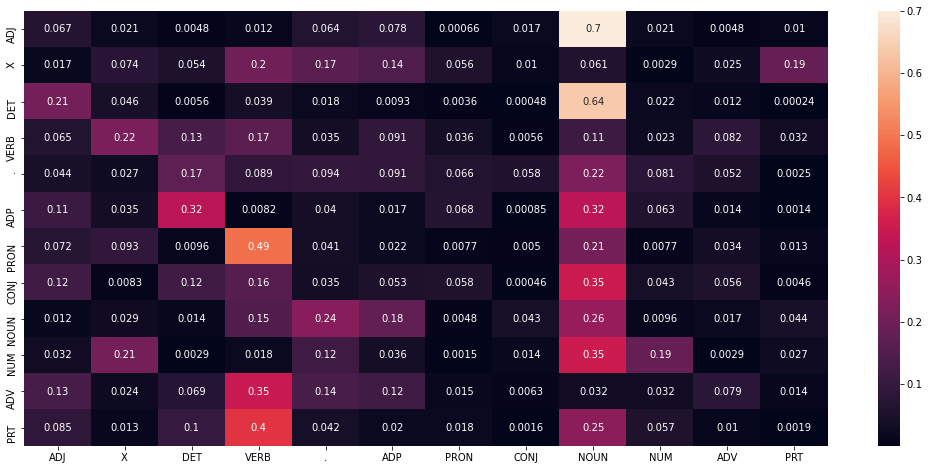

In [17]:
plt.figure(figsize=(18, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

Lets tweak the above graph to include only the frequent tags.

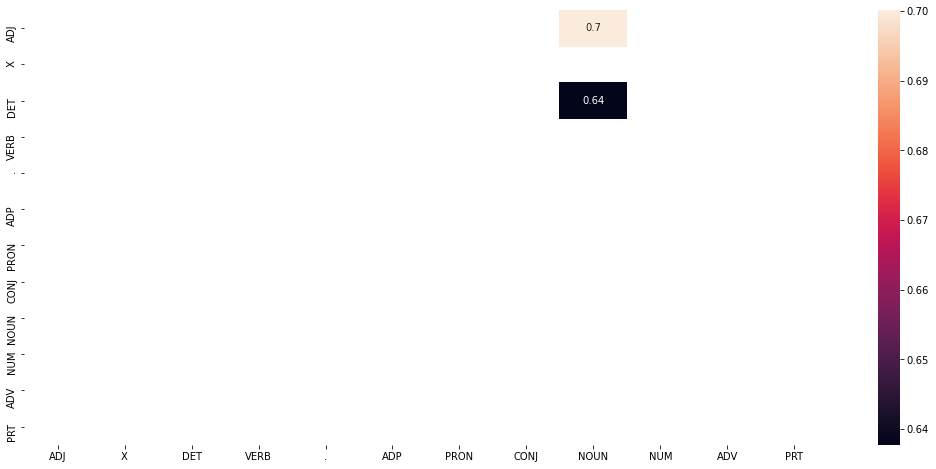

In [18]:
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 8))
sns.heatmap(tags_frequent, annot = True)
plt.show()

## Build the Vanilla Viterbi based POS tagger

Lets now build the base viterbi POS tagger.

In [19]:
# Viterbi Heuristic
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [20]:
random.seed(1234)

# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]


In [21]:
# tagging the test sentences
tagged_seq = Vanilla_Viterbi(test_tagged_words)

In [22]:
# Find out the accuracy of the Vanilla Viterbi Algorithm

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

vanilla_viterbi_accuracy = len(check)/len(tagged_seq)

print("Accuracy of Vanilla Viterbi Algorithm : ", vanilla_viterbi_accuracy)

Accuracy of Vanilla Viterbi Algorithm :  0.9229620145113103


We can see that our Vanilla Viterbi Algorithm achieves the accuracy of 92.2%. Though it is a good number but lets find out ways to improve it.

Lets have a look over the incorrectly tagged cases.

In [23]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

361


[[('as', 'ADP'), (('chief', 'NOUN'), ('chief', 'ADJ'))],
 [('assumed', 'VERB'), (('*-121', 'ADJ'), ('*-121', 'X'))],
 [('Chairman', 'NOUN'), (('Jay', 'ADJ'), ('Jay', 'NOUN'))],
 [('B.', 'NOUN'), (('Langner', 'ADJ'), ('Langner', 'NOUN'))],
 [('in', 'ADP'), (('excess', 'ADJ'), ('excess', 'NOUN'))],
 [('be', 'VERB'), (('better', 'ADV'), ('better', 'ADJ'))],
 [('*-1', 'X'), (('out', 'PRT'), ('out', 'ADP'))],
 [('reached', 'VERB'), (('*-24', 'ADJ'), ('*-24', 'X'))],
 [('from', 'ADP'), (('malnutrition', 'ADJ'), ('malnutrition', 'NOUN'))],
 [(',', '.'), (('chest', 'ADJ'), ('chest', 'NOUN'))],
 [('the', 'DET'), (('aftereffects', 'ADJ'), ('aftereffects', 'NOUN'))],
 [('of', 'ADP'), (('assaults', 'ADJ'), ('assaults', 'NOUN'))],
 [('federal', 'ADJ'), (('disaster', 'ADJ'), ('disaster', 'NOUN'))],
 [('to', 'PRT'), (('mend', 'ADJ'), ('mend', 'VERB'))],
 [('which', 'DET'), (('*T*-244', 'ADJ'), ('*T*-244', 'X'))],
 [('have', 'VERB'), (('deteriorated', 'ADJ'), ('deteriorated', 'VERB'))],
 [('in', 'ADP'

Let us now find out the proportion of unknown words(words that were not present in the training data but are in test data) in the incorrect cases. For this let us first find out unknown words.

In [24]:
# Unknown words 
test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print('\n')
print('#'*125)
print('\n')
print("Unknown Words")
print(unknown_words)

Total Unknown words : 283


#############################################################################################################################


Unknown Words
['Mount', 'Barbaresco', 'assert', 'Gottlieb', 'doctors', 'Yorker', 'distributed', 'Disease', '*-129', 'unethical', 'CTBS', 'Doak', 'Companies', 'incorporated', 'S.p.A.', 'Observing', 'Control', 'Johnson-era', 'unfunded', 'unleashed', 'Blackstone', 'Hurley', 'cardiovascular', 'sub-markets', 'Neanderthals', 'radically', 'sitting', 'possessed', 'diabetes', 'Berlin', 'inside', 'pre-approved', 'Danzig', 'Newspapers', 'twinned', 'deprived', '77.70', 'aspires', 'Rogers', 'witches', 'toy', 'nonfinancial', 'whimsical', 'anti-takeover', 'Notes', 'uncanny', 'B', 'recruit', 'depends', 'portray', 'noncompetitively', '1.39', 'fifth-largest', 'mortgaged', 'ON', 'stirrings', 'heebie-jeebies', 'Legislation', '*-161', 'worsen', 'sufficient', 'Varying', 'Solaia', 'deteriorated', 'Midwesco', 'bank-backed', 'powerhouse', '*T*-194', '23.72'

## Solve the problem of Unknown Words

> Let's try to improve the POS Tagging using the following approaches :

### Unigram Tagger

In [25]:
unigram_tagger = nltk.UnigramTagger(train_set)

#### Evaluating tagging accuracy

In [26]:
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("Accuracy of the Unigram Tagger is : ", unigram_tagger_accuracy)

Accuracy of the Unigram Tagger is :  0.9099445155783183


Let's now try combining the unigram tagger with a rule based regex tagger.

### Regex rules based tagger 

In [27]:
# patterns for tagging using a rule based regex tagger -
patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [28]:
# rule based RegexpTagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

#### Evaluating tagging accuracy

In [29]:
accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("Accuracy of the Unigram Tagger backed up by the RegexpTagger is :", accuracy_rule_based_unigram_tagger)

Accuracy of the Unigram Tagger backed up by the RegexpTagger is : 0.939820742637644


Lets try to improve the Unigram Tagger by using bigram tagger.

### Bigram Tagger

In [30]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)

0.9440887750746906

#### Evaluating tagging accuracy

In [31]:
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is :", accuracy_bigram_tagger)

The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is : 0.9440887750746906


Let us now see if there are any improvements using the trigram tagger.

### Trigram Tagger

In [32]:
# trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)

0.9415279556124626

#### Evaluating tagging accuracy

In [33]:
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is :", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the bigram_tagger is : 0.9415279556124626


### Modified Viterbi using trigram tagger as backoff

Above we have seen that the Trigram Tagger backed up by the bigram tagger gives an accuracy of about 94.8%.
Let us try using the trigram tagger as a backoff for the viterbi algorithm, in case of no matches for the trigram tagger, it will use the rule based tagger.

In [34]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed off by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [35]:
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in training_vocabulary_set:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [36]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

#### Evaluating tagging accuracy

In [37]:
# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("The accuracy of the Viterbi backed up by Trigram tagger is :", viterbi_trigram_accuracy)

The accuracy of the Viterbi backed up by Trigram tagger is : 0.9590268886043534


We have seen that the Vanilla Viterbi Algorithm had the accuracy as 92.2% whereas our Viterbi Algorithm backed up Trigram Tagger achieves an accuracy of 95.9%.

### Modified Viterbi using only transition probabilities for Unknown Words.

The Vanilla viterbi algorithm achieved an accuracy of about 92.2%. The cause of this 8% accuracy loss is mainly the case when the algorithm encountered unknown words i.e. words which were not present in the training set such as 'Twitter' etc.
For such words, the algorithm assigned an incorrect tag arbitarily. The reason beyond this is that the emission probabilities for unknown words for all tags is zero and thus the algorithm chooses the first tag which isn't a smart guess. Now, we need to find out a way to resolve this accuracy trade off for the unknown words.

Let's modify the vanilla viterbi algorithm in a way that if a word isn't present in the training vocabulary, it's emission probabilities will be zero and thus we can use transition probability and ignore the emission probability.

Let's define the algorithm more formally as: 

If Word is Unknown <br>

- Consider only Transition Probabilty

Else

- Consider both the Emission and Transition probability.

In [38]:
# Modified Viterbi Heuristic
def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in training_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [39]:
# tagging the test sentences
unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)

#### Evaluating tagging accuracy

In [40]:
# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

optimized_viterbi_accuracy = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("Accuracy of the Vanilla Viterbi Algorithm using only transition probability for Unknown words : ", optimized_viterbi_accuracy)

Accuracy of the Vanilla Viterbi Algorithm using only transition probability for Unknown words :  0.9466495945369184


Our modification of using Viterbi Algorithm with only transition probability in case of unknown words results in 94.6% accuracy which is better than the Vanilla Viterbi Algorithm which has 92.2.% accuracy.

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

Lets evaluate our different pos taggers on the test set that we initially created out of Penn Treebank Dataset.

In [52]:
accuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy*100], 
                  ['Unigram Tagger', unigram_tagger_accuracy*100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger*100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

accuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])
accuracy_data_df['Tagging_Accuracy'] = round(accuracy_data_df['Tagging_Accuracy'],2)
accuracy_data_df

,Tagging_Algorithm,Tagging_Accuracy
0,Vanilla Viterbi,92.30
1,Optimized Vanilla Viterbi,94.66
2,Unigram Tagger,90.99
3,Unigram + RegexpTagger,93.98
4,Bigram Tagger + Unigram_tagger,94.41
5,Trigram Tagger + Bigram_tagger,94.15
6,Viterbi + Trigram_tagger,95.90


In [59]:
fig = px.bar(accuracy_data_df, x='Tagging_Algorithm', y='Tagging_Accuracy',text='Tagging_Accuracy',color='Tagging_Accuracy',
            color_continuous_scale=px.colors.sequential.Cividis_r)
fig.update_traces(texttemplate='%{text}%', textposition='inside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()


We can see that our Viterbi Algorithm backed off with a Trigram tagger has the highest accuracy i.e. 95.9% among all the other algorithms.

### Lets check the tagging accuracies for the algorithm on the sample test sentences provided -

In [60]:
sample_test_sentences = ['Android is a mobile operating system developed by Google.',
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [61]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [62]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]


# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

In [63]:
sample_test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

#### 1. Testing the accuracy of Vanilla Viterbi on sample test data - 

In [64]:
# tagging the test sentences
sample_test_tagged_seq = Vanilla_Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_on_sample_test_data)

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 0.7679558011049724


#### 2. Testing the accuracy of Viterbi backed by a Trigram Tagger on sample test data - 

In [65]:
# tagging the test sentences
sample_test_viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)

# accuracy
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_trigram_accuracy = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is -", sample_test_viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is - 0.9281767955801105


#### 3. Testing the accuracy of Viterbi using only transition probabilities for unknown words on sample test data - 

In [66]:
# tagging the test sentences
sample_test_unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is -", sample_test_optimized_viterbi_accuracy)

The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is - 0.8895027624309392


### Comparing the accuracies of the 3 algorithm on sample test data -

In [71]:
accuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Vanilla Viterbi', sample_test_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', sample_test_viterbi_trigram_accuracy*100]]

sample_test_data_accuracy_df = pd.DataFrame(accuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])
sample_test_data_accuracy_df['Tagging_Accuracy'] = round(sample_test_data_accuracy_df['Tagging_Accuracy'],2)
display(sample_test_data_accuracy_df)

,Tagging_Algorithm,Tagging_Accuracy
0,Vanilla Viterbi,76.80
1,Optimized Vanilla Viterbi,88.95
2,Viterbi + Trigram_tagger,92.82


In [72]:
fig = px.bar(sample_test_data_accuracy_df, x='Tagging_Algorithm', y='Tagging_Accuracy',text='Tagging_Accuracy',color='Tagging_Accuracy',
            color_continuous_scale=px.colors.sequential.Cividis_r)
fig.update_traces(texttemplate='%{text}%', textposition='inside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()


We can see that for the sample test cases too, our Viterbi backed off with Trigram Tagger performed well with an accuracy of 92.82% where as the Vanilla Viterbi had only 76.8% accuracy.

### List down cases which were incorrectly tagged by original POS tagger & got corrected by your modifications -

In [73]:
# test sentences

test_sentence_1 = 'Android is a mobile operating system developed by Google.'
test_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
test_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
test_sentence_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
test_sentence_5 = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'
test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
test_sentence_7 = 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
test_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'
test_sentence_9 = 'I would like to see flights from Denver to Philadelphia.'
test_sentence_10 = 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
test_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

> ### Case - 1

In [74]:
# test_sentence_1 = 'Android is a mobile operating system developed by Google.'

words_test_sentence_1 = nltk.word_tokenize(test_sentence_1)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_1)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_sentence_1)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [75]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
tags_correction_df_1 = pd.DataFrame(columns = cols)
tags_correction_df_1 = tags_correction_df_1.fillna(0)

tags_correction_df_1.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction_df_1.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

tags_correction_df_1

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Android, ADJ)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)"
8,"(Google, ADJ)","(Google, NOUN)"
9,"(., .)","(., .)"


We can clearly see in the above output the Vanilla Viterbi tagged the word noun as Adjective where as our Viterbi backed off with Trigram Tagger tagged it as Noun which is correct.

> ### Case - 2

In [76]:
# test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, 
#                   an international football tournament contested once every four years.'

words_test_sentence_6 = nltk.word_tokenize(test_sentence_6)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_6 = Vanilla_Viterbi(words_test_sentence_6)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_6)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_6 = viterbi_backedup_by_trigram_tagger(words_test_sentence_6)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_6)

Tagging sequence with Vanilla_Viterbi -

 [('The', 'DET'), ('2018', 'ADJ'), ('FIFA', 'ADJ'), ('World', 'NOUN'), ('Cup', 'ADJ'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'ADJ'), ('FIFA', 'ADJ'), ('World', 'NOUN'), ('Cup', 'ADJ'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'ADJ'), ('contested', 'ADJ'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), 

In [77]:
tags_correction_df_6 = pd.DataFrame(columns = cols)
tags_correction_df_6 = tags_correction_df_6.fillna(0)

tags_correction_df_6.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_6]
tags_correction_df_6.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_6]

tags_correction_df_6

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(The, DET)","(The, DET)"
1,"(2018, ADJ)","(2018, NUM)"
2,"(FIFA, ADJ)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)"
4,"(Cup, ADJ)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)"
7,"(21st, ADJ)","(21st, NUM)"
8,"(FIFA, ADJ)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)"


We can clearly see that Vanilla Viterbi has made the following mistakes in tagging:
    - '2018' - PRT, 'FIFA' - PRT, 'Cup' - PRT, '21st' - PRT, 'tournament' - PRT, 'contested' - PRT.
where as Viterbi backed off by a Trigram Tagger had the following corrections in it:
    - '2018' - NUM, 'FIFA' - NOUN, 'Cup' - NOUN, '21st' - NUM, 'tournament' - NOUN, 'contested' - VERB.


> ### Case - 3

In [78]:
# test_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'

words_test_sentence_8 = nltk.word_tokenize(test_sentence_8)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_8 = Vanilla_Viterbi(words_test_sentence_8)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_8)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_8 = viterbi_backedup_by_trigram_tagger(words_test_sentence_8)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_8)

Tagging sequence with Vanilla_Viterbi -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'ADJ'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'NOUN'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


In [79]:
tags_correction_df_8 = pd.DataFrame(columns = cols)
tags_correction_df_8 = tags_correction_df_8.fillna(0)

tags_correction_df_8.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_8]
tags_correction_df_8.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_8]

tags_correction_df_8

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Show, NOUN)","(Show, NOUN)"
1,"(me, PRON)","(me, PRON)"
2,"(the, DET)","(the, DET)"
3,"(cheapest, ADJ)","(cheapest, ADJ)"
4,"(round, NOUN)","(round, NOUN)"
5,"(trips, ADJ)","(trips, NOUN)"
6,"(from, ADP)","(from, ADP)"
7,"(Dallas, NOUN)","(Dallas, NOUN)"
8,"(to, PRT)","(to, PRT)"
9,"(Atlanta, NOUN)","(Atlanta, NOUN)"


We can see that the Vanilla Viterbi algorithm tagged the word 'Trips' as PRT where as the Viterbi algorithm using back off as trigram tagger tagged it as Noun which is correct.

Now as we have seen that our modified version of Viterbi performs better than the Vanilla Viterbi Algorithm. To conclude this, we can now see the results on the whole test set for all the following three different approaches:
1. Vanilla Viterbi Algorithm
2. Viterbi using transition prob for unknown words
3. Viterbi backed off by a Trigram tagger

In [80]:
# Vanilla Viterbi Algorithm
sample_test_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(sample_test_tagged_words)
print("Tagging sequence with Vanilla_Viterbi -\n\n", sample_test_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('#'*120)

# Viterbi using transition probability for Unknown Words
sample_test_tagged_sequence_unknown_words = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)
print("Tagging sequence with viterbi using only transition probability for unknown words -\n\n", 
      sample_test_tagged_sequence_unknown_words)

print('\n')
print('#'*120)

# Viterbi backedd off by a Trigram Tagger
sample_test_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", sample_test_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.'), ('Android', 'ADJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADJ'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'ADJ'), ('since', 'ADP'), ('2011', 'ADJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADJ'), ('.', '.'), ('Google', 'ADJ'), ('and', 'CONJ'), ('Twitter', 'ADJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADJ'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADJ'), ("'s", 'PRT'), ('firehose', 'ADJ'), ('.', '.'), ('Twitter', 'ADJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on'

In [81]:
cols1 = ['actual_tags', 'as_tagged_by_vanilla_viterbi', 'as_tagged_by_Vanilla_Viterbi_for_Unknown_Words',
            'as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger']

tags_comparison_df = pd.DataFrame(columns = cols1)
tags_comparison_df = tags_comparison_df.fillna(0)

# Actual tags
tags_comparison_df.actual_tags = [tup for tup in sample_test_test_run_base]

# tags by vanilla viterbi
tags_comparison_df.as_tagged_by_vanilla_viterbi = [tup for tup in sample_test_tagged_sequence_with_vanilla_viterbi]

# tags by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_for_Unknown_Words = [tup for tup in sample_test_tagged_sequence_unknown_words]

# tags by viterbi_backedup_by_trigram_tagger - METHOD - 2
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger = [tup for tup in 
                                                                            sample_test_tagged_sequence_with_viterbi_trigram]

tags_comparison_df[tags_comparison_df.as_tagged_by_vanilla_viterbi != 
                   tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger]

,actual_tags,as_tagged_by_vanilla_viterbi,as_tagged_by_Vanilla_Viterbi_for_Unknown_Words,as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger
0,"(Android, NOUN)","(Android, ADJ)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, ADJ)","(Google, NOUN)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, ADJ)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, ADJ)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, ADJ)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, ADJ)","(smartphones, NOUN)","(smartphones, VERB)"
20,"(2011, NUM)","(2011, ADJ)","(2011, NOUN)","(2011, NUM)"
25,"(2013, NUM)","(2013, ADJ)","(2013, NOUN)","(2013, NUM)"
27,"(Google, NOUN)","(Google, ADJ)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, ADJ)","(Twitter, NOUN)","(Twitter, NOUN)"


## Conclusion

In the above analysis, we have seen the three different approaches for POS tagging. Initial one was the Vanilla Viterbi Algorithm for unknown words. In order to solve the problem of unknown words, we have mainly applied two different techniques which are as follows:
1. Viterbi Algorithm backed off by a Trigram Tagger
2. Viterbi using only transition probability for unknown words

Both the approaches resulted in improvement over the Vanilla Viterbi Algorithm which had an accuracy of 92.2% where first approach of using Viterbi Algorithm backed off by a Trigram Tagger had an accuracy of 95.9% and second approach of Viterbi Algorithm to use only transition probability for unknown words had an accuracy of 94.6%. Also, Viterbi backed off by a Trigram tagger has the highest accuracy for sample test sentences provided.

**Considering all the different approaches and their results, Viterbi Algorithm backed off by a Trigram tagger performs best with an accuracy of 95.9%.**